<a href="https://colab.research.google.com/github/dariashcherbakovaaa/Algorithms-for-massive-data/blob/draft/MBA_Shcherbakova00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market Basket Analysis on LinkedIn job skills and job links

###### **Daria Shcherbakova** *(DSE student, 17487A)*

## Environment settings & data loading

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName('Algo_Aprori').getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark
import pyspark
type(spark)

sc = spark.sparkContext
spark

In [2]:
# os.environ['KAGGLE_USERNAME'] = "xxxxxx"
# os.environ['KAGGLE_KEY'] = "xxxxxx"

In [3]:
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024 -f job_skills.csv
!unzip /content/job_skills.csv.zip -d job_skills

!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024 -f linkedin_job_postings.csv
!unzip linkedin_job_postings.csv.zip -d linkedin_job_postings

os.remove('/content/job_skills.csv.zip')
os.remove('/content/linkedin_job_postings.csv.zip')

Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
100% 196M/197M [00:02<00:00, 85.9MB/s]
100% 197M/197M [00:02<00:00, 79.8MB/s]
Archive:  /content/job_skills.csv.zip
  inflating: job_skills/job_skills.csv  
Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
 90% 85.0M/94.4M [00:01<00:00, 81.8MB/s]
100% 94.4M/94.4M [00:01<00:00, 70.5MB/s]
Archive:  linkedin_job_postings.csv.zip
  inflating: linkedin_job_postings/linkedin_job_postings.csv  


In [4]:
data_path = '/content/job_skills/job_skills.csv'
df_skills = spark.read.csv(data_path, inferSchema=True, header=True)
df_skills.printSchema()
df_skills.show()

root
 |-- job_link: string (nullable = true)
 |-- job_skills: string (nullable = true)

+--------------------+--------------------+
|            job_link|          job_skills|
+--------------------+--------------------+
|https://www.linke...|Building Custodia...|
|https://www.linke...|Customer service,...|
|https://www.linke...|Applied Behavior ...|
|https://www.linke...|Electrical Engine...|
|https://www.linke...|Electrical Assemb...|
|https://www.linke...|Access Control, V...|
|https://www.linke...|Consultation, Sup...|
|https://www.linke...|Veterinary Recept...|
|https://www.linke...|Optical Inspectio...|
|https://www.linke...|HVAC, troubleshoo...|
|https://www.linke...|Host/Server Assis...|
|https://www.linke...|Apartment mainten...|
|https://www.linke...|Fiber Optic Cable...|
|https://www.linke...|CT Technologist, ...|
|https://ca.linked...|SAP, DRMIS, Data ...|
|https://www.linke...|Debt and equity o...|
|https://ca.linked...|Biomedical Engine...|
|https://www.linke...|Laboratory

In [5]:
data_path = '/content/linkedin_job_postings/linkedin_job_postings.csv'
df_all = spark.read.csv(data_path, inferSchema=True, header=True)
df_all.printSchema()
df_all.show()

root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: string (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)

+--------------------+--------------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+---------------+--------------+--------------------+----------+--------+
|            job_link| last_processed_time|got_summary|got_ner|is_being_worked|           job_title|             company|        job_location|first_seen|    search_c

## Data pre-processing

#### Additional dataset to select actual job

In [6]:
df_all = df_all[['job_link', 'job_title', 'search_country', 'search_position', 'job_level']]
df_all.show(10)

+--------------------+--------------------+--------------+--------------------+----------+
|            job_link|           job_title|search_country|     search_position| job_level|
+--------------------+--------------------+--------------+--------------------+----------+
|https://www.linke...|Account Executive...| United States|         Color Maker|Mid senior|
|https://www.linke...|Registered Nurse ...| United States|Director Nursing ...|Mid senior|
|https://www.linke...|RESTAURANT SUPERV...| United States|            Stand-In|Mid senior|
|https://www.linke...|Independent Real ...| United States|   Real-Estate Clerk|Mid senior|
|https://www.linke...|Group/Unit Superv...| United States|Supervisor Travel...|Mid senior|
|https://www.linke...|  Counselor-07532802| United States| Residence Counselor|Mid senior|
|https://www.linke...|Registered Nurse ...| United States|  Nurse Practitioner|Mid senior|
|https://www.linke...|Part Time- HR Gen...| United States|Human Resource Ad...|Mid senior|

In [7]:
df_all.describe()

summary,job_link,job_title,search_country,search_position,job_level
count,1348488,1348488,1348420,1348420,1348420
mean,null,null,null,null,null
stddev,null,null,null,null,null
min,"New""","""""""A"""" Softball C...",2024-01-13,Able Seaman,Administrative As...
max,https://za.linked...,"🔥Nurse Manager, ...",United States,Zoo Veterinarian,United States


In [8]:
df_all = df_all.where((df_all['job_level'] == 'Mid senior') & (df_all['search_country'] == 'United States'))
df_all.show(10)

+--------------------+--------------------+--------------+--------------------+----------+
|            job_link|           job_title|search_country|     search_position| job_level|
+--------------------+--------------------+--------------+--------------------+----------+
|https://www.linke...|Account Executive...| United States|         Color Maker|Mid senior|
|https://www.linke...|Registered Nurse ...| United States|Director Nursing ...|Mid senior|
|https://www.linke...|RESTAURANT SUPERV...| United States|            Stand-In|Mid senior|
|https://www.linke...|Independent Real ...| United States|   Real-Estate Clerk|Mid senior|
|https://www.linke...|Group/Unit Superv...| United States|Supervisor Travel...|Mid senior|
|https://www.linke...|  Counselor-07532802| United States| Residence Counselor|Mid senior|
|https://www.linke...|Registered Nurse ...| United States|  Nurse Practitioner|Mid senior|
|https://www.linke...|Part Time- HR Gen...| United States|Human Resource Ad...|Mid senior|

In [9]:
df_all.groupBy('job_title')\
      .count()\
      .orderBy('count', ascending=False)\
      .show()

+--------------------+-----+
|           job_title|count|
+--------------------+-----+
|LEAD SALES ASSOCI...| 7305|
|       Shift Manager| 5727|
|First Year Tax Pr...| 5350|
|LEAD SALES ASSOCI...| 4888|
|   Assistant Manager| 4606|
|Customer Service ...| 4599|
|CUSTOMER SERVICE ...| 4195|
|       Store Manager| 3929|
|Hourly Supervisor...| 2941|
|Travel Allied Hea...| 2920|
|    Registered Nurse| 2783|
|                Host| 2779|
|Hourly Supervisor...| 2227|
|  Restaurant Manager| 2135|
|OPERATIONS ASSIST...| 2062|
|Assistant General...| 1952|
|        Veterinarian| 1947|
|   Senior Accountant| 1914|
|   Account Executive| 1824|
|Department Superv...| 1685|
+--------------------+-----+
only showing top 20 rows



In [10]:
import re

pattern_danalyst = r'\bdata\sanal\w*' # data analyst
pattern_banalyst = r'\bbusiness\sanal\w*' # business analyst
pattern_scientist = r'\bdata\sscientist\w*' # data scientist
pattern_engineer = r'\bdata\sengin\w*' #data engenineer

In [11]:
from pyspark.sql.functions import col, lower, regexp_extract

df_all_sampled = df_all.filter(
    (lower(col('job_title')).rlike(pattern_danalyst)) |
    (lower(col('job_title')).rlike(pattern_banalyst)) |
    (lower(col('job_title')).rlike(pattern_scientist)) |
    (lower(col('job_title')).rlike(pattern_engineer))
)
print((df_all_sampled.count(), len(df_all_sampled.columns)))

(7038, 5)


In [12]:
new_names = ['link', 'job_title', 'country', 'serach', 'level']

df_all_sampled = df_all_sampled.toDF(*new_names)
df_all_sampled.limit(5)\
              .toPandas() # i like pandas view more

,link,job_title,country,serach,level
0,https://www.linkedin.com/jobs/view/secret-clea...,Secret cleared Business Analyst,United States,Quality Assurance Analyst,Mid senior
1,https://www.linkedin.com/jobs/view/business-an...,Business Analyst (11076-1),United States,Consultant Education,Mid senior
2,https://www.linkedin.com/jobs/view/payment-swi...,Payment (Swift) (Business Analyst),United States,Instructor Business Education,Mid senior
3,https://www.linkedin.com/jobs/view/principal-b...,Principal Business Analyst,United States,Management Analyst,Mid senior
4,https://www.linkedin.com/jobs/view/lead-data-e...,Lead Data Engineer,United States,Maintenance Data Analyst,Mid senior


#### The main dataset with links and skills

In [13]:
new_names = ['link', 'skill']

df_skills = df_skills.toDF(*new_names)
df_skills.show(5)

+--------------------+--------------------+
|                link|               skill|
+--------------------+--------------------+
|https://www.linke...|Building Custodia...|
|https://www.linke...|Customer service,...|
|https://www.linke...|Applied Behavior ...|
|https://www.linke...|Electrical Engine...|
|https://www.linke...|Electrical Assemb...|
+--------------------+--------------------+
only showing top 5 rows



In [14]:
df_skills.describe()

summary,link,skill
count,1296381,1294374
mean,null,null
stddev,null,null
min,https://ae.linked...,"""* Maintenance, *..."
max,https://za.linked...,"志愿服务, 沟通, 陪伴, 临终服..."


In [15]:
df_skills = df_skills.dropna() # drop empty, NA cells
df_skills = df_skills.dropDuplicates() # drop repeated cells

df_skills.describe()

summary,link,skill
count,1294374,1294374
mean,null,null
stddev,null,null
min,https://ae.linked...,"""* Maintenance, *..."
max,https://za.linked...,"志愿服务, 沟通, 陪伴, 临终服..."


#### data merging and sampling

In [16]:
df_skills.groupBy('skill') \
         .count() \
         .orderBy('count', ascending=False) \
         .show() # first attempt to check the most "frequent" set of skills in dataset

+--------------------+-----+
|               skill|count|
+--------------------+-----+
|Front Counter, Dr...|  169|
|Front Counter, Dr...|  112|
|Communication, Co...|   90|
|Retail experience...|   83|
|Leadership, Train...|   75|
|VolunteerMatch, L...|   70|
|                None|   50|
|Food Safety, Inte...|   47|
|Supervisory exper...|   41|
|Food Safety, Inte...|   40|
|             Nursing|   38|
|This context does...|   36|
|Restaurant Manage...|   35|
|Physician, Obstet...|   33|
|Retail experience...|   32|
|Customer service ...|   32|
|Communication ski...|   31|
|Leadership, Train...|   30|
|Teamwork, Positiv...|   29|
|Restaurant Manage...|   29|
+--------------------+-----+
only showing top 20 rows



In [17]:
data = df_all_sampled.join(df_skills,['link'],how='inner')
data.count()

6795

In [18]:
data = data[['link', 'skill']]
data.limit(5)\
    .toPandas()

,link,skill
0,https://www.linkedin.com/jobs/view/aflcmc-busi...,"Business Analyst, DoD financial management pro..."
1,https://www.linkedin.com/jobs/view/business-an...,"Data analysis, SQL, Database management, Macro..."
2,https://www.linkedin.com/jobs/view/business-an...,"Business Analysis, Business Process Review, Re..."
3,https://www.linkedin.com/jobs/view/business-an...,"Alteryx Analytics, SQL, Data Validation, Alter..."
4,https://www.linkedin.com/jobs/view/business-an...,"Data Analysis, Process Improvement, Technology..."


#### EDA

In [19]:
df_pd = data.toPandas()
df_pd.shape

(6795, 2)

In [20]:
skills = df_pd['skill'].str.split(', ').explode()
df = pd.DataFrame(skills, index=None)
df.shape

(180380, 1)

In [21]:
counting = df.value_counts().sort_values(ascending = 0)
counting

skill                     
SQL                           3023
Python                        2388
Communication                 1704
Data Analysis                 1703
Project Management            1230
                              ... 
Rate analysis                    1
Rate changes                     1
Rate design                      1
Rates and Forms Management       1
Éditions Documentaires           1
Name: count, Length: 41020, dtype: int64

<Axes: xlabel='skill'>

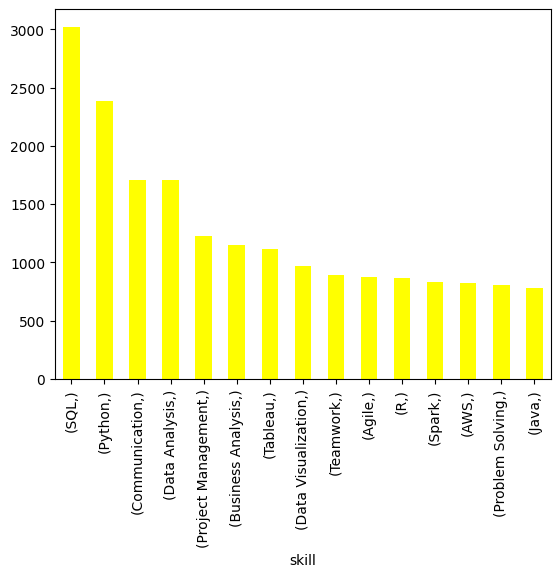

In [117]:
counting[:15].plot.bar(color = 'yellow')

## MBA I part: turning data into baskets

In [23]:
rdd = data.select(data.columns[1]).rdd
baskets = rdd.map(lambda x: x['skill']) \
             .map(lambda line: line.split(', '))
baskets.take(1)

[['Business Analyst',
  'DoD financial management processes',
  'Government financial and accounting systems',
  'Acquisition and budgeting processes',
  'Relational databases',
  'Financial and technical consulting',
  'Government finance expertise',
  'Financial data structuring',
  'Reconciliation between systems',
  'Financial forecasts and accounting data review',
  'Government financial office support',
  'Cost and Requirement System (CCaR™) experience',
  "Bachelor's degree in business management engineering computer science mathematics economics",
  '7+ years of government acquisition finance financial management program management or related experience',
  '10+ years of equivalent technical training or work/military experience',
  'Extended periods of sitting typing hearing seeing and speaking',
  'Prolonged computer work and typing',
  'Accurate communication',
  '15 lbs lifting/carrying',
  'Office mobility',
  'Federal background investigation',
  'Travel',
  'Varying work 

In [ ]:
# lenghts = baskets.map(lambda x: len(x))
#
# print(f"Max number of items in the basket is: {lenghts.max()}\n",
#       f"The average number of items in the basket is: {lenghts.mean()}\n",
#       f"The total number of baskets is: {baskets.count()}\n",
#       f"The approximate total number of items is:{round(lenghts.mean() * baskets.count())}", sep = '\n')

## MBA II part: apriori algorithm implementation

In [128]:
from itertools import combinations

In [193]:
def a_apriori(baskets, s, hash_table, k):
  """The first phase of algo: count occurencies of each item, select candidate item"""

  candidate_items = baskets.flatMap(lambda basket: [(item, 1) for item in basket]) \
                           .reduceByKey(lambda x1, x2: x1 + x2) \
                           .filter(lambda x: x[1] > s)


  top5 = candidate_items.takeOrdered(5, key=lambda x: -x[1])
  top_candidates_idx = [idx for idx, _ in top5]
  top_candidates = [list(hash_table.keys())[idx] for idx in top_candidates_idx]

  """The second phase of algo: create candidate pairs and check the frequency"""

  candidates = set(candidate_items.map(lambda x: (x[0],)).collect())

  candidate_itemsets = baskets.flatMap(lambda basket: [(itemset, 1) for itemset in combinations(sorted(basket), k)
                                                        if all(item in candidates for item in combinations(itemset, k-1))
                                                        ]) \
                              .reduceByKey(lambda x, y: x + y) \
                              .filter(lambda x: x[1] > s)

  top15 = candidate_itemsets.takeOrdered(15, key=lambda x: -x[1])
  top_pairs_idx = [pair for pair, _ in top15]
  top_idxs = [(idx1, idx2) for idx1, idx2 in top_pairs_idx]
  top_сandidate_itemsets = [(list(hash_table.keys())[idx1], list(hash_table.keys())[idx2]) for idx1, idx2 in top_idxs]


  return candidate_items, top_candidates, candidate_itemsets, top_сandidate_itemsets

In [58]:
def supp(baskets, percentage):
  s = round(baskets.count() * percentage / 100)
  return s

support = supp(baskets, 1)
print(f"The support value is {support}")

The support value is 68


In [59]:
items = baskets.flatMap(lambda line: line) \
               .distinct()
items.take(5)

['Test cases',
 'Test data preparation',
 'Project status communication',
 'Airflow',
 'Mentoring']

In [60]:
items_index = items.zipWithIndex() \
                   .collectAsMap()

for elem, index in list(items_index.items())[:15]:
  print(f"{elem}: {index}")

print(f"\n\nThe total number of skills is {len(items_index)}")

Test cases: 0
Test data preparation: 1
Project status communication: 2
Airflow: 3
Mentoring: 4
Schema design: 5
PPC: 6
Supplier registration: 7
Stakeholder communication: 8
Computer skills: 9
Technical support: 10
Ability to work under pressure: 11
Cloud Technology: 12
Status Reporting: 13
Worldclass technology talent provision: 14


The total number of skills is 41020


In [61]:
def hashing(basket):
    return {items_index[skill] for skill in basket}

hashed_baskets = baskets.map(hashing)
hashed_baskets.take(1)

[{406,
  2240,
  2456,
  4099,
  6756,
  7168,
  7376,
  7764,
  9033,
  13664,
  13873,
  16413,
  16414,
  16614,
  19043,
  19693,
  20314,
  20923,
  22561,
  23187,
  23816,
  28149,
  29175,
  31035,
  32075,
  32937,
  32938,
  33317,
  36753,
  37372,
  38453,
  39282}]

In [ ]:
candidate_items, top_candidates, candidate_itemsets, top_сandidate_itemsets = a_apriori(hashed_baskets, support, items_index, 2)
print(f"The total number of frequent skills: {candidate_items.count()} ---> our candidate items")
print(f"Top-5 frequent skills: {', '.join(top_candidates)}")
print(f"The total number of frequent skills pairs: {candidate_itemsets.count()}")
print(f"Top-15 skills pairs: {top_сandidate_itemsets}")


### A-PRIORY

In [53]:
def apriori(baskets, support, hash_table, k):
  '''Fist phase to count occurencies of each item'''

  candidate_items = baskets.flatMap(lambda basket: [(item, 1) for item in basket]) \
                           .reduceByKey(lambda count1, count2: count1 + count2) \
                           .filter(lambda item_count: item_count[1] > support)

  print(f'The total number of candidate items is {candidate_items.count()}')

  best_candidate_idx = candidate_items.max(lambda x: x[1])
  best_candidate = (list(hash_table.keys())[list(hash_table.values()).index(best_candidate_idx[0])])
  print(f"The most frequent item (our candidate) is: {best_candidate}")

  top_candidates = [(hash_table[item[0]].key(), item[1]) for item in candidate_items.takeOrdered(3, key=lambda x: x[1])]
  print(f"The frequent items (our candidates) are: {top_candidates}")


  # '''The second phase to count all pair composed of frequent singletons'''
  candidates = set(candidate_items.map(lambda x: (x[0],)).collect())

  # candidate_itemsets = baskets.flatMap(lambda basket: [
  #     (tuple(sorted(itemset)), 1) for itemset in combinations(sorted(basket), k) if all(item in candidates for item in combinations(itemset, k))]) \
  #                             .reduceByKey(lambda x, y: x + y) \
  #                             .filter(lambda x: x[1] > support)

  # print(f'The total number of candidate pairs is {candidate_itemsets.count()}')

  #   # Find Top 5 Frequent Pairs
  # top_itemsets = candidate_itemsets.takeOrdered(5, key=lambda x: -x[1])
  # frequent_pairs = [(hash_table[itemset[0][0]], hash_table[itemset[0][1]], itemset[1]) for itemset in top_itemsets]

  # return candidates#, candidate_itemsets, frequent_pairs

In [71]:
apriori(hashed_baskets, support, items_index, 2)

KeyboardInterrupt: 

## DRAFT: Data transformation into baskets, hashing + algo

In [ ]:
class Basketorization:
    def __init__(self, data):
        self.data = data

    def create_baskets(self):

        """ Create baskets from data """

        rdd = self.data.select(data.columns[1]).rdd
        baskets = rdd.map(lambda x: x['skill']).map(lambda line: line.split(', '))
        return baskets

    def calculate_support(self, baskets, percentage):

        """Calculate support based on percentage"""

        support_value = round(baskets.count() * percentage / 100)
        return support_value

    def analyse_baskets(self, baskets):

            # """ Do simple EDA """

        lengths = baskets.map(lambda x: len(x))
        return {
            "The size of the biggest basket": lengths.max(),
            "On average, the size of the basket is": lengths.mean(),
            "The total number of baskets is": baskets.count(),
            "The approximate total number of items is": round(lengths.mean() * baskets.count())
        }

    def item_indexing(self, baskets):
      '''Create hash table (distinct item - distinct index)'''
      items = baskets.flatMap(lambda line: line) \
                     .distinct()
      items_index = items.zipWithIndex() \
                         .collectAsMap() # return a dictionary of (key, value) pairs
      print(f"The total number of skills is {len(items_index)}")
      return items_index

    def hashing(self, baskets, items_index):
      '''Hash each item of the basket with its index'''

      def hash_basket(basket):
        '''Transform baskets into sets'''
        hashed_basket = [items_index.get(skill, -1) for skill in baskets]
        return hashed_basket

      hashed_baskets = baskets.map(hash_basket)
      return hashed_baskets

    def basketarise(self, percentage):

        """Run the basket creation, calculate support, and analysis steps"""

        baskets = self.create_baskets()
        analysis = self.analyse_baskets(baskets)
        support_value = self.calculate_support(baskets, percentage)
        items_index = self.item_indexing(baskets)
        hash_table = self.hashing(baskets,items_index)
        baskets_hashed = baskets.map(self.hashing)

        return analysis, support_value, baskets, baskets_hashed, items_index, hash_table

In [ ]:
data_mba = Basketorization(data)
analysis, support, baskets, baskets_hashed, items_index, hash_table  = data_mba.basketarise(1)
print(f"The basic exploratory analysis: {analysis}")
print(f"Support value is: {support}")

The total number of skills is 41020
The basic exploratory analysis: {'The size of the biggest basket': 224, 'On average, the size of the basket is': 26.54598969830757, 'The total number of baskets is': 6795, 'The approximate total number of items is': 180380}
Support value is: 68


In [ ]:
for elem, index in list(items_index.items())[:15]:
  print(f"{elem}: {index}")

Test cases: 0
Test data preparation: 1
Project status communication: 2
Airflow: 3
Mentoring: 4
Schema design: 5
PPC: 6
Supplier registration: 7
Stakeholder communication: 8
Computer skills: 9
Technical support: 10
Ability to work under pressure: 11
Cloud Technology: 12
Status Reporting: 13
Worldclass technology talent provision: 14


In [ ]:
def first_pass(baskets_hashed, hash_table, support):

    '''Do the first pass of algo = count occurencies of each item'''

    frst_pass = baskets_hashed.flatMap(lambda basket: [(skill, 1) for skill in baskets_hashed]) \
                        .reduceByKey(lambda x, y: x + y) \
                        .filter(lambda x: x[1]>support)

    '''Check that it works  = due to support threshold we have frequent items (skills)'''
    try:
      frst_pass_count = frst_pass.count()
      if frst_pass_count == 0:
        raise ValueError('There are no frequent items')
    except ValueError as e:
      print('Low your support')
      print(e)
      return

    print(f"The number of frequent singletons is: {frst_pass_count}")

    '''Ask to see the most frequent items (skill)'''

    freq_items_idx = frst_pass.max(lambda x: x[1])
    freq_items = (list(hash_table.keys())[list(hash_table.values()).index(freq_items_idx[0])])
    print(f"The most frequent singleton:{freq_items}")

In [ ]:
class Apriory:
  def __init__(self, baskets, support, hash_table):
    self.baskets = baskets
    self.support = support
    self.hash_table = hash_table

  def first_pass(self):

    '''Do the first pass of algo = count occurencies of each item'''

    frst_pass = self.baskets.flatMap(lambda basket: [(skill,1) for skill in basket]) \
                        .reduceByKey(lambda x,y: x+y) \
                        .filter(lambda x: x[1]>self.support)

    '''Check that it works  = due to support threshold we have frequent items (skills)'''
    try:
      frst_pass_count = frst_pass.count()
      if frst_pass_count == 0:
        raise ValueError('There are no frequent items')
    except ValueError as e:
      print('Low your support')
      print(e)
      return

    print(f"The number of frequent singletons is: {frst_pass_count}")

    '''Ask to see the most frequent item (skill)'''

    freq_sngltn_idx = frst_pass.max(lambda x: x[1])
    freq_sngltn = (list(self.hash_table.keys())[list(self.hash_table.values()).index(freq_sngltn_idx[0])])
    print(f"The most frequent singleton:{freq_sngltn}")

  def second_pass(self):
      # Collect frequent singletons on driver
      frequent_singletons = set(self.first_pass.map(lambda x: (x[0],)).collect())
      k = 2
      while True:
        print(f"The basket size is: {k}")

        candidate_itemsets = self.baskets.flatMap(lambda basket:[(skill,1) for skill in combinations(sorted(basket),k) if all(item in frequent_singletons for item in combinations(skill,k-1))])
        scnd_pass = candidate_itemsets.reduceByKey(lambda x,y: x+y)
        scnd_pass_count = scnd_pass.count()  # Call count outside flatMap

        if scnd_pass_count != 0:
          # Rest of your code for processing frequent itemsets
          frequencies = set(scnd_pass.map(lambda x: x[0]).collect())
          k += 1
        else:
          print(f"There is no frequent {k}-plets itemsets")
          return
          break

In [ ]:
def a_priori(baskets_collection,support,hash_table):

  print("Frequent singletons")

  first_pass = baskets_collection.flatMap(lambda basket: [(skill,1) for skill in basket]) \
                                .reduceByKey(lambda x,y: x+y) \
                                .filter(lambda x: x[1]>support)

  first_pass_count = first_pass.count()

  if first_pass_count == 0:
    print("Lower the support")
    return

  print("Number of frequent singletons:",first_pass_count)

  max_s = first_pass.max(lambda x: x[1])
  max_s_ = (list(hash_table.keys())[list(hash_table.values()).index(max_s[0])])
  print("Most frequent singleton:",max_s_)

  freqs = set(first_pass.map(lambda x: (x[0],)).collect())

  print()

  k = 2

  while True:

    print("Itemesets of size:",k)

    pass_ = baskets_collection.flatMap(lambda basket:[(elem,1) for elem in combinations(sorted(basket),k) if
                                                      all(item in freqs for item in combinations(elem,k-1))]) \
                              .reduceByKey(lambda x,y: x+y) \
                              .filter(lambda x: x[1]>support)

    pass_count = pass_.count()

    if pass_count != 0:
      print("Number of frequent itemsets of size",k,"are:",pass_count)

      max_p = pass_.max(lambda x: x[1])
      max_itemset = []
      for skill in max_p[0]:
        max_itemset.append(list(hash_table.keys())[list(hash_table.values()).index(skill)])
      print("Most frequent itemset of size",k,"is composed by:",max_itemset)

      freqs = set(pass_.map(lambda x: x[0]).collect())

      print()

      k+=1

    else:
      print("There are no frequent itemsets of size",k)
      print("Given the monotonicity of itemsets, there are no more frequent itemsets.")
      break